In [ ]:
import math
import pandas_datareader as web
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [ ]:
#Get the stock quote
df = yf.download('AAPL', start = '2012-01-01', end='2019-12-17')
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.482926,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.550011,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.689342,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.821992,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.801655,394024400
...,...,...,...,...,...,...
2019-12-10,67.150002,67.517502,66.464996,67.120003,65.565018,90420400
2019-12-11,67.202499,67.775002,67.125000,67.692497,66.124252,78756800
2019-12-12,66.945000,68.139999,66.830002,67.864998,66.292747,137310400


In [ ]:
df.shape

(2002, 6)

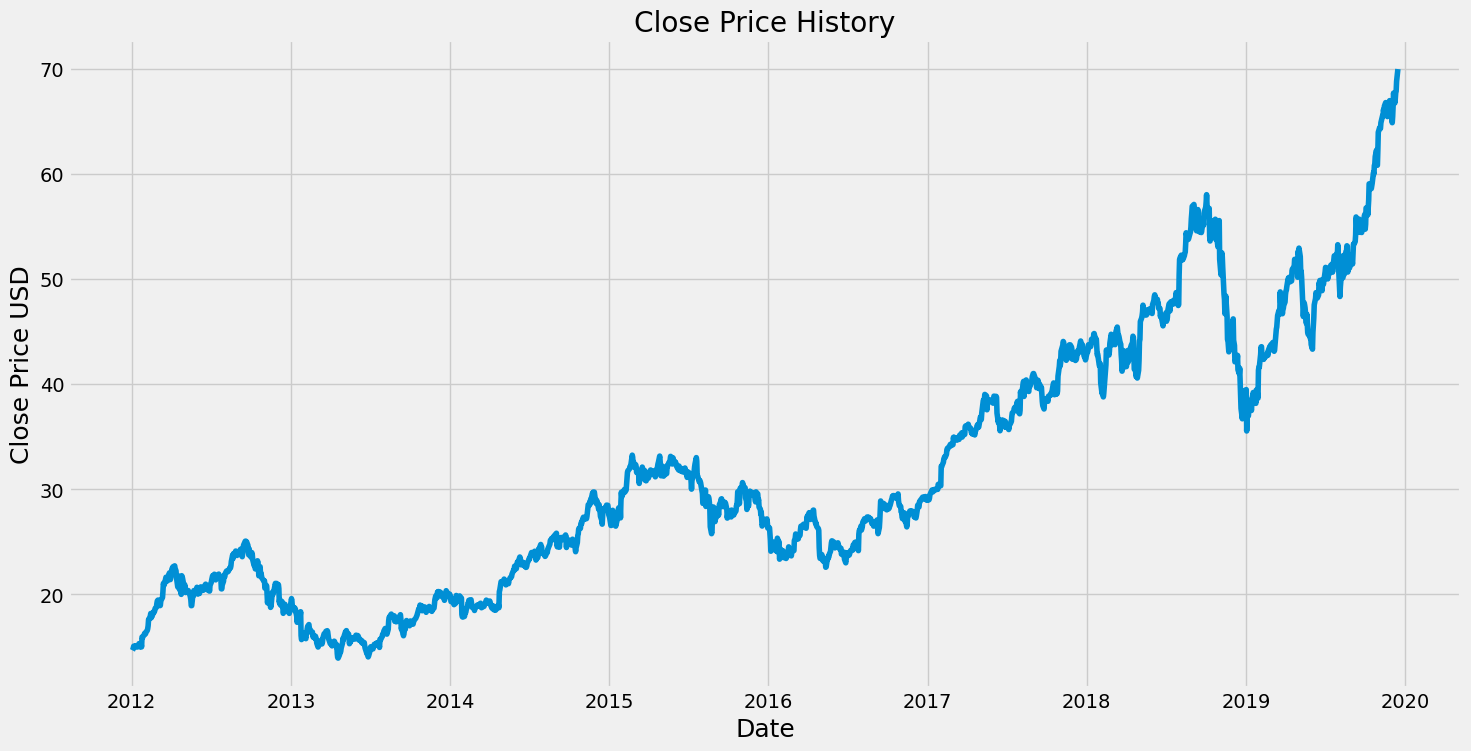

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD', fontsize=18)
plt.show()

In [ ]:
data=df.filter(['Close'])
dataset = data.values
training_data_len = math.ceil(len(dataset) * .8)

training_data_len

1602

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.0131974 ],
       [0.01460639],
       [0.01753278],
       ...,
       [0.96251174],
       [0.97897982],
       [1.        ]])

In [ ]:
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])
  if i <=60:
    print(x_train)
    print(y_train)
    print()

[array([0.0131974 , 0.01460639, 0.01753278, 0.0203189 , 0.01989174,
       0.02085445, 0.02041453, 0.01967497, 0.01866762, 0.02178528,
       0.02459691, 0.02372983, 0.01898002, 0.02351306, 0.01905016,
       0.03578601, 0.03449178, 0.0361813 , 0.03983449, 0.0420468 ,
       0.04186191, 0.04117973, 0.04408699, 0.04682209, 0.04992063,
       0.05492545, 0.06543874, 0.06559812, 0.0714509 , 0.07582451,
       0.06830775, 0.07120224, 0.07114487, 0.07926096, 0.07810697,
       0.08024277, 0.08408086, 0.08621669, 0.0923691 , 0.0968511 ,
       0.09814534, 0.09859802, 0.09093461, 0.08908567, 0.08935984,
       0.09656423, 0.09859166, 0.10294617, 0.1132108 , 0.12690551,
       0.12434252, 0.12434889, 0.13425015, 0.13734869, 0.13514271,
       0.13312806, 0.13103049, 0.13799896, 0.14278065, 0.14478257])]
[0.139835129205152]



In [ ]:
x_train = np.array(x_train)
y_train = np.array(y_train)

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
x_train.shape

(1542, 60, 1)

In [ ]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

1542/1542 [==============================] - 54s 33ms/step - loss: 7.3886e-04


In [ ]:
test_data = scaled_data[training_data_len - 60:, :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range (60, len(test_data)):
  x_test.append(test_data[i-60:i,0])

In [ ]:
x_test = np.array(x_test)

In [ ]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

13/13 [==============================] - 1s 16ms/step


In [ ]:
rmse = np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

1.3945168594955304

<ipython-input-23-f6325784669a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


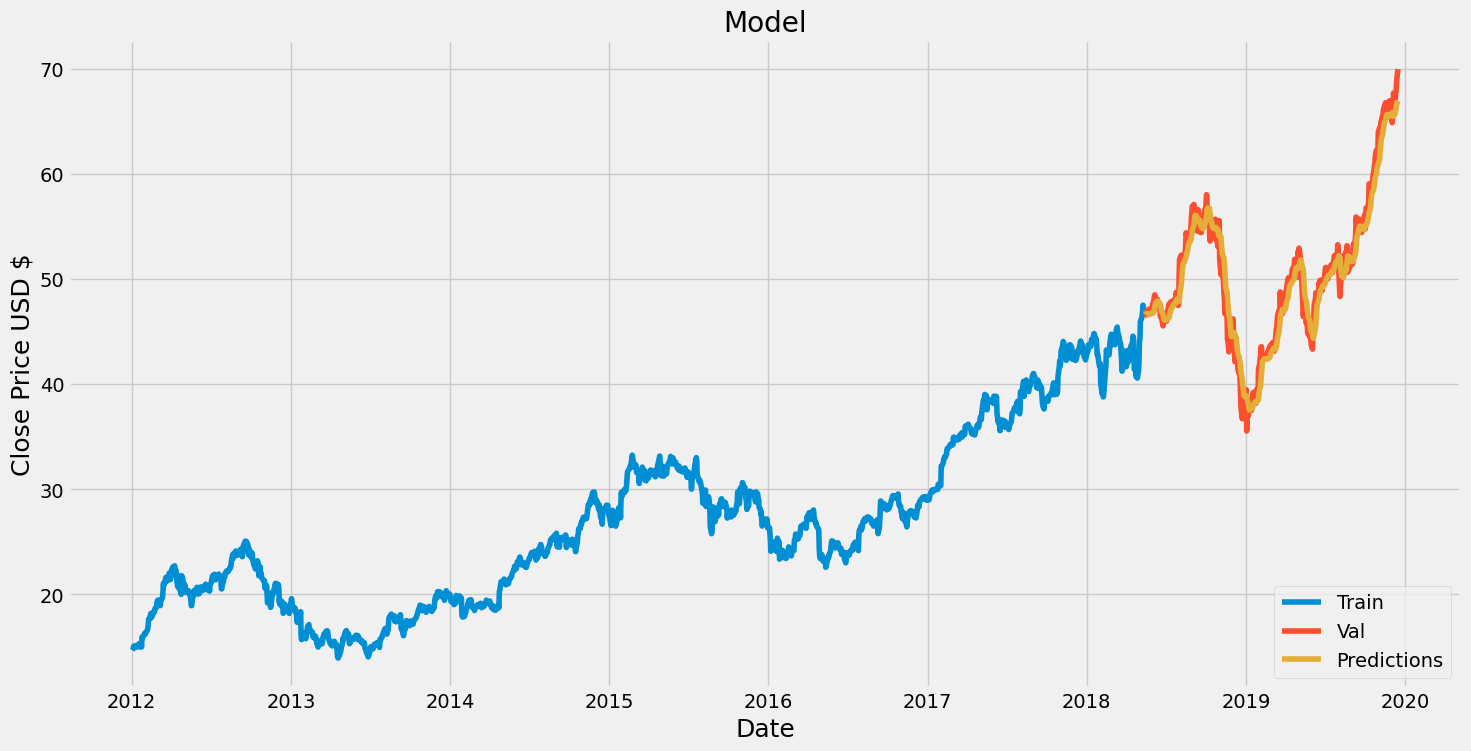

In [ ]:
train = data[: training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price USD $', fontsize = 18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
# Show the valid and predicted prices

valid

,Close,Predictions
Date,,
2018-05-16,47.044998,46.611198
2018-05-17,46.747501,46.698700
2018-05-18,46.577499,46.710945
2018-05-21,46.907501,46.664173
2018-05-22,46.790001,46.641010
...,...,...
2019-12-10,67.120003,65.879616
2019-12-11,67.692497,66.076782
2019-12-12,67.864998,66.328659


In [ ]:
apple_quote = yf.download('AAPL', start = '2012-01-01', end = '2019-12-17')
new_df = apple_quote.filter(['Close'])
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)
X_test = []
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 30ms/step
[[67.45782]]


In [ ]:
apple_quote2 = yf.download('AAPL', start = '2019-12-18', end = '2019-12-19')
print(apple_quote2['Close'])


[*********************100%***********************]  1 of 1 completed
Date
2019-12-18    69.934998
Name: Close, dtype: float64
